## Task 1: Installing and Importing Libraries

In [20]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import datetime, timedelta
from IPython.display import display, clear_output
import ipywidgets as widgets

# Skyfield for astronomy
from skyfield.api import load, EarthSatellite, Topos, wgs84

# Cartopy for map plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Task 2: Fetching ISS Two-Line Element (TLE) Data

In [21]:
def fetch_iss_tle():
    url = "https://celestrak.org/NORAD/elements/stations.txt"
    try:
        response = requests.get(url)
        response.raise_for_status()
        lines = response.text.splitlines()
        for i, line in enumerate(lines):
            if "ISS" in line:
                tle_line1 = lines[i + 1].strip()
                tle_line2 = lines[i + 2].strip()
                return tle_line1, tle_line2
    except Exception as e:
        print("Failed to fetch TLE:", e)
        return None, None

tle1, tle2 = fetch_iss_tle()
print("TLE Line 1:", tle1)
print("TLE Line 2:", tle2)

TLE Line 1: 1 25544U 98067A   25200.17124576  .00006153  00000+0  11590-3 0  9995
TLE Line 2: 2 25544  51.6335 148.5331 0002204  94.5231 265.6010 15.49949392520127


## Task 3: Calculating ISS Pass Times for a Given Location

In [22]:
def compute_next_pass(latitude, longitude):
    ts = load.timescale()
    t0 = ts.now()
    t1 = ts.now() + timedelta(days=1)

    satellite = EarthSatellite(tle1, tle2, 'ISS (ZARYA)', ts)
    observer = Topos(latitude_degrees=latitude, longitude_degrees=longitude)

    t, events = satellite.find_events(observer, t0, t1, altitude_degrees=30.0)
    event_names = ['Rise', 'Culminate', 'Set']
    for ti, event in zip(t, events):
        print(f'{event_names[event]} at {ti.utc_strftime()}')

compute_next_pass(28.6, 77.2)  # New Delhi

Rise at 2025-07-19 18:36:49 UTC
Culminate at 2025-07-19 18:38:02 UTC
Set at 2025-07-19 18:39:14 UTC
Rise at 2025-07-20 09:38:23 UTC
Culminate at 2025-07-20 09:39:11 UTC
Set at 2025-07-20 09:39:59 UTC


## Task 4: Visualizing the ISS Ground Track

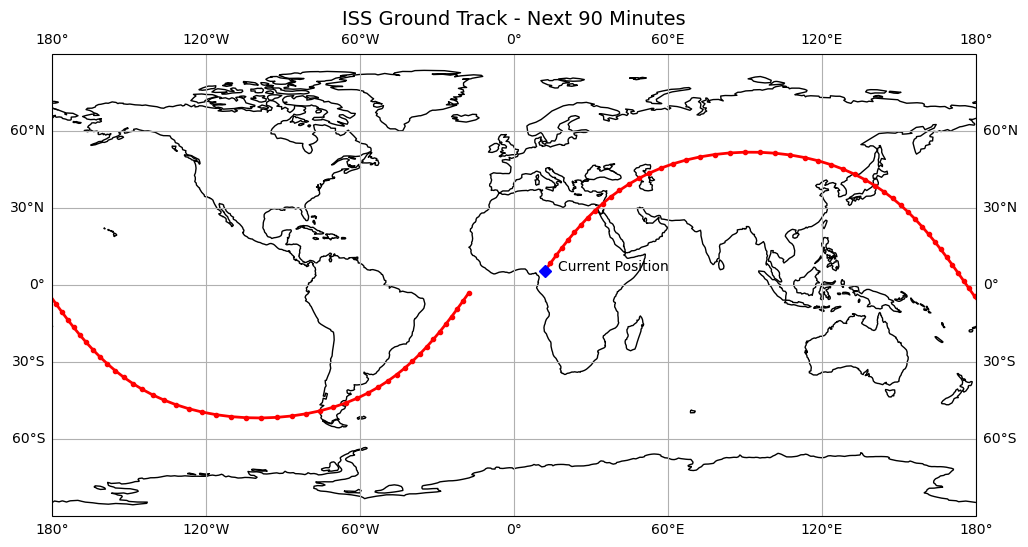

In [23]:
stations_url = 'https://celestrak.org/NORAD/elements/stations.txt'
satellites = load.tle_file(stations_url)
iss = [sat for sat in satellites if sat.name == 'ISS (ZARYA)'][0]

# Time sampling: next 90 minutes, 1-minute interval
ts = load.timescale()
t0 = ts.now()
times = ts.utc([t0.utc_datetime() + timedelta(minutes=i) for i in range(91)])


# Get latitude and longitude from subpoints
lats, lons = [], []
for t in times:
    subpoint = iss.at(t).subpoint()
    lats.append(subpoint.latitude.degrees)
    lons.append(subpoint.longitude.degrees)

# Plotting on world map with Cartopy
plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_title("ISS Ground Track - Next 90 Minutes", fontsize=14)

# Plot path
ax.plot(lons, lats, color='red', linewidth=2, marker='o', markersize=3, transform=ccrs.Geodetic())

# Mark current position
ax.plot(lons[0], lats[0], marker='D', color='blue', markersize=6, transform=ccrs.Geodetic())
plt.text(lons[0] + 5, lats[0], 'Current Position', transform=ccrs.Geodetic(), fontsize=10)

plt.show()


## Task 5: Predicting Passes Over Multiple Locations

In [24]:
import pandas as pd
from pathlib import Path

locations_data = {
    "Location": ["New Delhi", "Mumbai", "Chennai", "Bangalore", "Hyderabad"],
    "Latitude": [28.6, 19.07, 13.08, 12.97, 17.38],
    "Longitude": [77.2, 72.87, 80.27, 77.59, 78.48]
}

df_locations = pd.DataFrame(locations_data)

csv_path = Path("D:/CodeProjects/Notebook/locations.csv")
df_locations.to_csv(csv_path, index=False)

csv_path.name

'locations.csv'

## Task 6: Interactive Exploration with Widgets

In [25]:
stations_url = 'https://celestrak.org/NORAD/elements/stations.txt'
satellites = load.tle_file(stations_url)
iss = [sat for sat in satellites if 'ISS' in sat.name][0]

locations_df = pd.read_csv("locations.csv")

location_dropdown = widgets.Dropdown(
    options=locations_df["Location"],
    description="📍 Location:"
)

window_slider = widgets.IntSlider(
    value=1440,         # default 1 day
    min=60,             # minimum 1 hour
    max=4320,           # up to 3 days
    step=60,
    description="⏱️ Window (mins):"
)

run_button = widgets.Button(
    description="🚀 Predict Passes",
    button_style='success'
)

output_area = widgets.Output()

def on_run_button_clicked(b):
    with output_area:
        clear_output()
        try:
            loc_name = location_dropdown.value
            loc_data = locations_df[locations_df["Location"] == loc_name].iloc[0]
            lat, lon = loc_data["Latitude"], loc_data["Longitude"]
            minutes_ahead = window_slider.value

            ts = load.timescale()
            t0 = ts.now()
            t1 = t0 + timedelta(minutes=minutes_ahead)

            observer = wgs84.latlon(latitude_degrees=lat, longitude_degrees=lon)

            t_events, events = iss.find_events(observer, t0, t1, altitude_degrees=10.0)
            event_names = ['\nRise', 'Culminate', 'Set']

            if not t_events:
                print("🚫 No visible ISS passes in the selected time window.")
                return

            for t, e in zip(t_events, events):
                print(f"{event_names[e]} at {t.utc_strftime()} UTC")

            rise_times = [t.utc_datetime() for t, e in zip(t_events, events) if e == 0]

            if rise_times:
                fig, ax = plt.subplots(figsize=(12, 4))
                ax.plot(rise_times, [1] * len(rise_times), 'ro')

                margin = timedelta(minutes=10)
                ax.set_xlim([min(rise_times) - margin, max(rise_times) + margin])

                ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
                ax.xaxis.set_major_locator(mdates.AutoDateLocator())
                plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, fontsize=8)

                ax.set_title(f" ISS Rise Events over {loc_name}", fontsize=12)
                ax.set_xlabel("Time (UTC)", fontsize=10)
                ax.set_yticks([])
                ax.grid(True)
                plt.tight_layout()
                plt.show()
            else:
                print(" No 'rise' events found in this time window.")

        except Exception as e:
            print("Error:", e)

run_button.on_click(on_run_button_clicked)
display(location_dropdown, window_slider, run_button, output_area)

Dropdown(description='📍 Location:', options=('New Delhi', 'Mumbai', 'Chennai', 'Bangalore', 'Hyderabad'), valu…

IntSlider(value=1440, description='⏱️ Window (mins):', max=4320, min=60, step=60)

Button(button_style='success', description='🚀 Predict Passes', style=ButtonStyle())

Output()

## Task 7: Advanced Analysis – Orbital Drift over Time

Orbital Elements from Current TLE:
Inclination:    51.63°
Eccentricity:   0.000225
Orbital Period: 21292.73 minutes


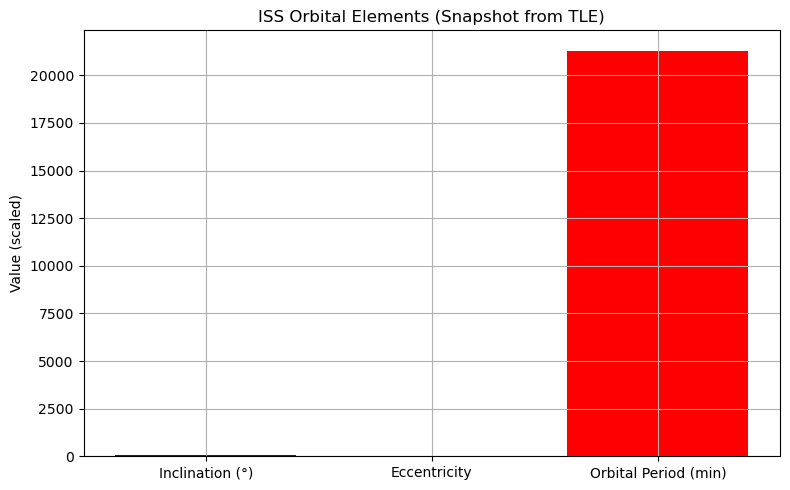

In [26]:
file_path = "D:/CodeProjects/Notebook/stations.txt"

with open(file_path, 'r') as file:
    lines = file.readlines()
    tle1 = lines[1].strip()
    tle2 = lines[2].strip()

ts = load.timescale()
satellite = EarthSatellite(tle1, tle2, 'ISS (ZARYA)', ts)
model = satellite.model

try:
    inclination = model.inclo * (180 / 3.14159)  # Radians to degrees
    eccentricity = model.ecco
    mean_motion = model.no_kozai
    period = 1440.0 / mean_motion if mean_motion != 0 else float('nan')

    print("Orbital Elements from Current TLE:")
    print(f"Inclination:    {inclination:.2f}°")
    print(f"Eccentricity:   {eccentricity:.6f}")
    print(f"Orbital Period: {period:.2f} minutes")

    labels = ['Inclination (°)', 'Eccentricity', 'Orbital Period (min)']
    values = [inclination, eccentricity * 1000, period]

    plt.figure(figsize=(8, 5))
    plt.bar(labels, values, color=['blue', 'green', 'red'])
    plt.title('ISS Orbital Elements (Snapshot from TLE)')
    plt.ylabel('Value (scaled)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("Error reading TLE data:", e)